In [6]:
from snn_delays.datasets.custom_datasets import CustomDataset
from snn_delays.config import DATASET_PATH
from torch.utils.data import DataLoader
import os

from tonic import MemoryCachedDataset
import numpy as np

#data = np.load(os.path.join(DATASET_PATH, 'raw_datasets', 'Letters', 'letter_classification_dataset.npz'))
data = np.load(os.path.join(DATASET_PATH, 'raw_datasets', 'Letters', 'three_letter_classification_dataset.npz'))

train_data = data['train_data']
test_data = data['test_data']
train_labels= data['train_labels']
test_labels = data['test_labels']

num_samples = len(train_labels)

train_dataset = CustomDataset(train_data, train_labels)
test_dataset = CustomDataset(test_data, test_labels)

dataset_dict = train_dataset.get_train_attributes()

cached_train_dataset = MemoryCachedDataset(train_dataset)
cached_test_dataset = MemoryCachedDataset(test_dataset)

total_time = train_data.shape[1]
print(f'num timesteps per sample: {total_time}')
batch_size = 128

train_loader = DataLoader(cached_train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=0)

test_loader = DataLoader(cached_test_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=0)

dataset_dict["time_ms"] = 1e3
dataset_dict["dataset_name"] = "letters"

print(dataset_dict)

num timesteps per sample: 48
{'num_input': 25, 'num_training_samples': 8000, 'num_output': 20, 'time_ms': 1000.0, 'dataset_name': 'letters'}


In [7]:
for i, l in test_loader:
    print(i.shape)
    break

torch.Size([128, 48, 1, 25])


Delays(all):50\
Delays(3coarse):47%\
Delays(3fine): 47%
Recurrent: 43, 47% after 26 epochs\
Feedforward:40

In [13]:
from snn_delays.snn import SNN
from snn_delays.utils.train_utils import train, get_device
from snn_delays.utils.test_behavior import tb_save_max_last_acc
import time

device = get_device()
num_epochs = 100
lr = 1e-3

taimu1 = time.time()

tau_m = 'normal'
#delay = (48*2,16*2)
#delay = (96,32)
delay = None
#delay = (total_time, 1)
#delay = (total_time, total_time//3)
#delay = (3, 1)
ckpt_dir = 'exp23_letters_memory' 

snn = SNN(dataset_dict=dataset_dict, structure=(64, 2), connection_type='r',
    delay=delay, delay_type='h', tau_m = tau_m,
    win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device,
    debug=True)

snn.set_network()

snn.model_name = f'letters{delay}'+ snn.model_name

snn.to(device)
train(snn, train_loader, test_loader, lr, num_epochs, dropout=0.0, 
    test_behavior=tb_save_max_last_acc, ckpt_dir=ckpt_dir, scheduler=(100, 0.95), test_every=1)

print(f'[INFO] TIEMPO: {time.time() - taimu1}', flush=True)

Running on: cuda:0

[INFO] Delays: tensor([0])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([0])

[INFO] Delays o: tensor([0])
1000.0
Delta t: 20.833333333333332 ms
mean of normal: -0.6064646446020864
training lettersNoneletters48_l2_1d1.t7 for 100 epochs...
Epoch [1/100], learning_rates 0.001000, 0.100000
Step [20/62], Loss: 2.95485
l1_score: 0
Step [40/62], Loss: 2.96107
l1_score: 0
Step [60/62], Loss: 2.86583
l1_score: 0
Time elasped: 19.287636756896973
Test Loss: 3.0935159623622894
Avg spk_count per neuron for all 48 time-steps 3.086205244064331
Avg spk per neuron per layer [6.0916328125, 6.2531875]
Test Accuracy of the model on the test samples: 8.100

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp23_letters_memory
saving max acc: 8.1
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp23_letters_memory
Epoch [2/100], learning_rates 0.001000, 0.100000
Step [20/62], Loss: 2.79531
l1_sc

KeyboardInterrupt: 

Test Loss: 3.307549476623535
Avg spk_count per neuron for all 16 time-steps 0.819427490234375
Avg spk per neuron per layer [2.0072021484375, 1.2705078125]
Test Accuracy of the model on the test samples: 7.812

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


<Axes: xlabel='Time (ms)', ylabel='Neuron'>

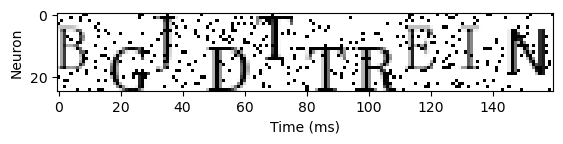

In [5]:
from snn_delays.utils.visualization_utils import plot_raster
snn.test(test_loader, only_one_batch=True)
plot_raster(snn, 'input', 10)